# Label Data
- Take in screenshots of game
- Grab balls and save crops of individual balls
- User input for labeling and grouping ball types into their own folders

In [1]:
import project
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
from pathlib import Path

constants = json.load(open('constants.json'))
print(constants.keys())

dict_keys(['playable_area', 'pockets'])


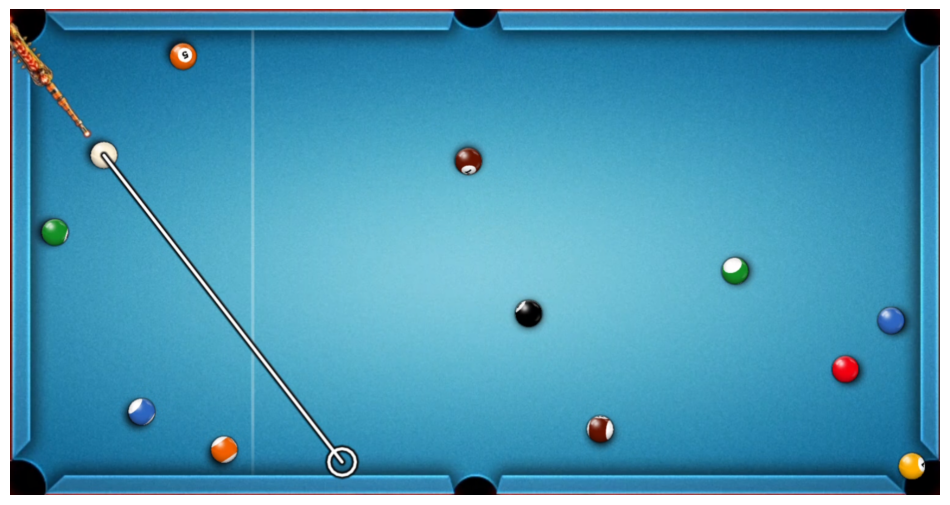

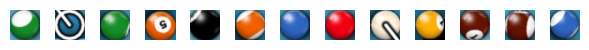

In [ ]:
# demo of screenshot -> crop individual balls
img = cv2.imread('screenshots/screenshot_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# crop image to playable area
img = img[constants['playable_area']['top_left'][1]:constants['playable_area']['bottom_right'][1],
            constants['playable_area']['top_left'][0]:constants['playable_area']['bottom_right'][0]]
data = project.generate_data(img, use_blue=True, k_1=2, k_2=1,
                             min_dist=40, canny=20, accum=20, min_radius = 20, max_radius=30)
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.axis('off')
plt.show()

n_plots = len(data)
fig, axes = plt.subplots(1, n_plots, figsize=(6,6))

for i in range(n_plots):
    axes[i].imshow(data[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# take images from screenshots directory -> crop individual balls
img = cv2.imread('screenshots/screenshot_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# crop image to playable area
img = img[constants['playable_area']['top_left'][1]:constants['playable_area']['bottom_right'][1],
            constants['playable_area']['top_left'][0]:constants['playable_area']['bottom_right'][0]]
data = project.generate_data(img, use_blue=True, k_1=2, k_2=1,
                             min_dist=40, canny=20, accum=20, min_radius = 20, max_radius=30)
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.axis('off')
plt.show()

n_plots = len(data)
fig, axes = plt.subplots(1, n_plots, figsize=(6,6))

for i in range(n_plots):
    axes[i].imshow(data[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()